In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, accuracy_score, 
    matthews_corrcoef, precision_recall_curve, average_precision_score
)

# 让 SVG 保留可编辑文本（不转曲线）
#plt.rcParams["svg.fonttype"] = "none"

sns.set(style="white", font_scale=1.2)
def evaluate_model(dfc, dfpred, prefix="./results/evaluation", optimal_threshold=0.5):
    y_true = dfc.response_label.map({'R': 1, 'NR': 0}).values
    y_pred_prob = dfpred['$P_{R}$'].values

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    prc_auc = average_precision_score(y_true, y_pred_prob)
    positive_ratio = y_true.mean()  # 随机预测的基线

    # Threshold
    y_pred = (y_pred_prob >= optimal_threshold).astype(int)

    # Metrics
    mcc = matthews_corrcoef(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    # --- Subplots: 1 row x 3 cols ---
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), 
                                        width_ratios = [1,1,1.2])  # 适合横排投图
    (ax1, ax2, ax3) = axes
    # --- ROC on ax1 ---
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve', fontsize=14,  pad=20)
    ax1.legend(loc='lower right')

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.tick_params(axis='both', which='both', direction='out',
                    length=5, width=1, bottom=True, left=True)

    # --- PRC on ax2 ---
    ax2.plot(recall, precision, color='green', lw=2, label=f'PRC AUC = {prc_auc:.2f}')
    ax2.hlines(positive_ratio, 0, 1, colors='gray', linestyles='--', lw=1,
               ) #label=f'Random = {positive_ratio:.2f}'
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve', fontsize=14,  pad=20)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='lower left')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(axis='both', which='both', direction='out',
                    length=5, width=1, bottom=True, left=True)

    for ax in [ax1, ax2]:
        ax.set_xticks([0, 0.5, 1])
        ax.set_yticks([0, 0.5, 1])
    
    # --- Confusion Matrix on ax3 ---
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NR', 'R'], yticklabels=['NR', 'R'],
                cbar=False, ax=ax3, square=True)
    ax3.set_xlabel('Predicted Label')
    ax3.set_ylabel('True Label')
    ax3.set_title(f'Confusion Matrix (thr={optimal_threshold:.2f})'
                  , fontsize=14,  pad=20)

    for ax in axes:
        ax.title.set_fontweight('bold')

    # Layout & save as SVG
    fig.tight_layout()
    fig.savefig(f"{prefix}.svg", bbox_inches="tight")
    #plt.close(fig)
    fig.savefig(f"{prefix}.png", dpi=300, bbox_inches="tight")
    
    # --- Print metrics ---
    print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')
    print(f'Accuracy (ACC): {acc:.4f}')
    print(f'Average Precision (AUPRC): {prc_auc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    return fig

In [2]:
import pandas as pd

In [3]:
dfcx = pd.read_csv('./data/AMADEUS_Post_TPM.tsv', index_col = 0, sep = '\t')
df_label = pd.read_csv('./data/AMADEUS_Post_Clinical.tsv', index_col = 0, sep = '\t')
#df_label['response_label'] = df_label['responder.flag.crpr'].map({'N':'NR', 'Y':"R"})

In [4]:
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/aliyun_sync/COMPASS/')
from baseline.immnue_score.scorer import ssGSEA
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label,plot_performance, score2
from compass.tokenizer import CANCER_CODE, CONCEPT
from compass.tokenizer import CONCEPT_palette
from compass.utils import plot_sankey_diagram, get_projector_weights

/home/shenwanxiang/anaconda3/envs/compass/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# load the pretrained model as a feature extractor
finetuner = loadcompass('../checkpoint/latest/finetuner_pft_all.pt', map_location='cpu')
genesetprojector = finetuner.model.latentprojector.genesetprojector
cellpathwayprojector = finetuner.model.latentprojector.cellpathwayprojector

In [6]:
dfgn, dfgs, dfct = finetuner.extract(dfcx,  batch_size= 32, with_gene_level = True)
_, dfpred = finetuner.predict(dfcx,  batch_size= 32)

100%|#####################################################################################| 1/1 [00:00<00:00,  1.37it/s]


In [7]:
dfpred.columns = ['$P_{NR}$', '$P_{R}$']
dfp = df_label.join(dfpred)
dfp['pred_response'] = dfp['$P_{R}$'].apply(lambda x:'R' if x>0.5 else 'NR')

In [8]:
dfp.to_csv('./results/post_prediction.tsv', sep ='\t')

In [9]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from shap.plots import colors
from lifelines.utils import concordance_index as lfcindex
from samecode.survival.plot import KMPlot

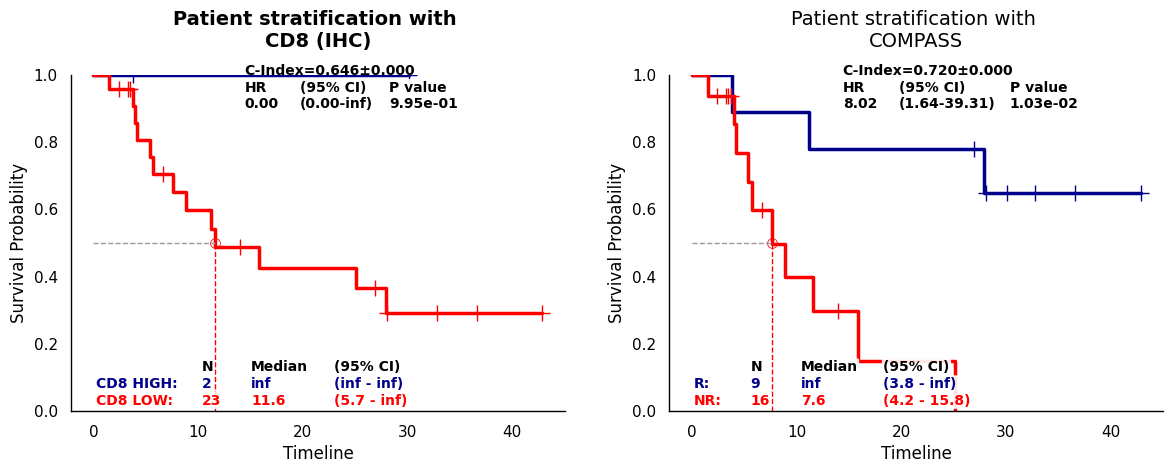

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (12,5))

comparisons = [['NR', 'R', '']]
colors = ['darkblue', 'red']


KMPlot(dfp, time='os.months', event='os.event.flag', 
       label=['arm']).plot(ax=axs[0],colors = colors,
                           
                           
                                     labels=['CD8 HIGH','CD8 LOW', ], 
                                     comparisons = [['CD8 HIGH','CD8 LOW', '' ]],
                                    hr_color = 'black',
                                    x_legend = 0.05, y_legend = 0.12, legend_font_size=10, 
                                    x_hr_legend = 0.3, y_hr_legend = 0.95, hr_font_size=10,
                                    linewidth=2.5)

ax=axs[0]
cindex = lfcindex(dfp['os.months'], 
                  dfp['cd8.percent.baseline'], dfp['os.event.flag'])

cindex_format = "C-Index={:.3f}±{:.3f}".format(cindex.mean(),cindex.std() )
ax.text(0.35, 1, cindex_format,  transform=ax.transAxes,   
        weight='bold', fontsize=10, color='black');
title = f'Patient stratification with \nCD8 (IHC)'
ax.set_title(title, fontsize=14,  pad=20)  # pad=20 weight='bold',
ax.title.set_fontweight('bold')


KMPlot(dfp, time='os.months', event='os.event.flag', 
       label=['pred_response']).plot(ax=axs[1],
                                     labels=['R','NR', ], 
                                     
                                     comparisons = comparisons,
                                     colors = colors,
                                    hr_color = 'black',
                                    x_legend = 0.05, y_legend = 0.12, legend_font_size=10, 
                                    x_hr_legend = 0.3, y_hr_legend = 0.95, hr_font_size=10,
                                    linewidth=2.5)


ax=axs[1]
cindex = lfcindex(dfp['os.months'], 
                  dfp['$P_{R}$'], dfp['os.event.flag'])

cindex_format = "C-Index={:.3f}±{:.3f}".format(cindex.mean(),cindex.std() )
ax.text(0.35, 1, cindex_format,  transform=ax.transAxes,   
        weight='bold', fontsize=10, color='black');
title = f'Patient stratification with \nCOMPASS'
ax.set_title(title, fontsize=14,  pad=20)  # pad=20 weight='bold',

for ax in axs:
    ax.set_ylim(0,1)
    #ax.set_xlim(0,xmax)
    ax.xaxis.label.set_fontweight('normal')
    ax.yaxis.label.set_fontweight('normal')

sns.despine(offset=0)
fig.tight_layout(w_pad=2)

fig.savefig(f'./results/Post_KM_plot.svg', bbox_inches = 'tight')

Text(0, 0.5, 'C-index')

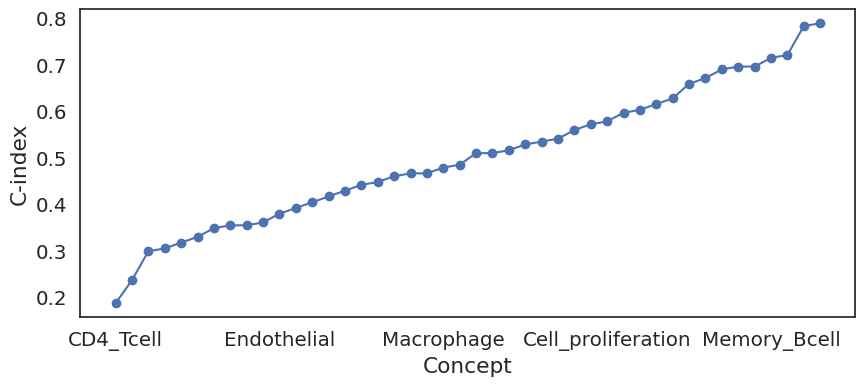

In [11]:
dfps  = dfp[dfp.arm=='CD8 LOW'].join(dfct)
res={}
for col in dfct.columns:    
    cindex = lfcindex(dfps['os.months'], dfps[col], dfps['os.event.flag'])
    res.update({col:cindex})
dfres = pd.Series(res).sort_values()


fig,ax = plt.subplots(figsize = (10, 4))
dfres.plot(kind = 'line', ls = '-', ax=ax, marker='o')
#ax.set_xticklabels(labels = dfres.index.tolist(), 
#                   rotation=90)
ax.set_xlabel('Concept')
ax.set_ylabel('C-index')

In [12]:
dfp.columns

Index(['manuscript.id', 'arm', 'treatment', 'crossover.to.ipi.nivo',
       'crossover.day', 'age', 'sex', 'race', 'ethnicity', 'tumor.type',
       'tumor.type.abbr', 'prior.lines.of.therapy', 'ecog.screening',
       'stage.at.diagnosis', 'stage.at.enrollment',
       'treatment.duration.months', 'cd8.percent.baseline',
       'cd8.percent.max.ontrt', 'best.overall.response', 'pfs.months',
       'pfs.event.flag', 'os.months', 'os.event.flag', 'responder.flag.crpr',
       'disease.control.flag', 'cd8.converter.flag', 'msi', 'tmb',
       'response_label', 'tumor.type.tcga', '$P_{NR}$', '$P_{R}$',
       'pred_response'],
      dtype='object')

Matthews Correlation Coefficient (MCC): 0.6225
Accuracy (ACC): 0.8182
Average Precision (AUPRC): 0.5742
ROC AUC: 0.8190


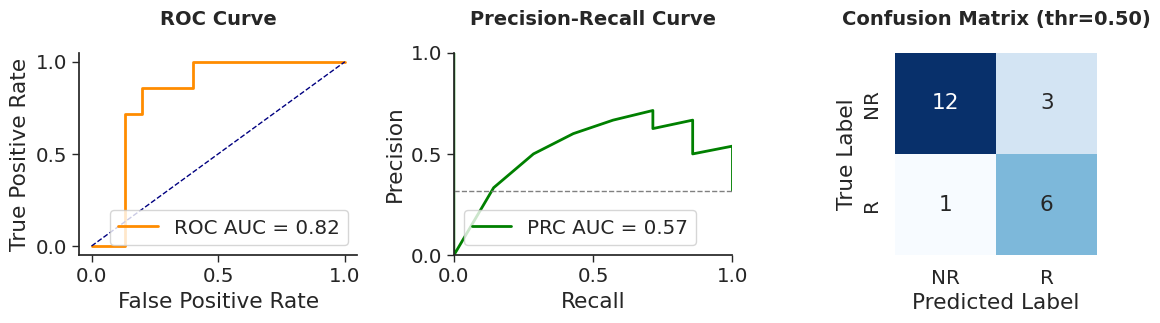

In [13]:
dfc0 = df_label[~df_label.response_label.isna()]
dfp0 = dfpred.loc[dfc0.index]
fig = evaluate_model(dfc0, dfp0, prefix='./results/Post_evaluation',)